In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
!pip install mlxtend imblearn xgboost
import zipfile
import os

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from scipy.stats import pearsonr

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix

from sklearn.feature_selection import mutual_info_classif

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from imblearn.under_sampling import NearMiss

from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from xgboost import XGBClassifier

In [ ]:
import zipfile
import pandas as pd
import os

# Define the path to the zip file
zip_file_path = '/content/archive (1).zip'  # Corrected path

# Check if the zip file exists
if not os.path.exists(zip_file_path):
    print(f"Error: zip file not found at {zip_file_path}")
else:
    # Create a directory to extract the contents
    extraction_path = '/extracted_data'
    os.makedirs(extraction_path, exist_ok=True)

    # Extract the contents of the zip file
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extraction_path)
            extracted_files = zip_ref.namelist() # Get a list of extracted file names
        print(f"Extracted {len(extracted_files)} files to {extraction_path}")
    except zipfile.BadZipFile:
        print(f"Error: {zip_file_path} is not a valid zip file.")
    except Exception as e:
        print(f"Error during extraction: {e}")

    # After extraction, list files in the directory to find CSV files
    if os.path.exists(extraction_path):
        all_files = os.listdir(extraction_path)
        csv_files = [f for f in all_files if f.lower().endswith('.csv')]

        if not csv_files:
            print(f"Error: No CSV files found in the extracted directory {extraction_path}")
        elif len(csv_files) >= 1:
            if len(csv_files) >= 1:
                file1_path = os.path.join(extraction_path, csv_files[0])
                try:
                    file1 = pd.read_csv(file1_path)
                    print(f"\n--- Head of file1 --- (Path: {file1_path})")
                    print(file1.head().to_markdown(index=False, numalign="left", stralign="left"))
                except Exception as e:
                    print(f"Error reading file1 ({csv_files[0]}): {e}")
            if len(csv_files) >= 2:
                file2_path = os.path.join(extraction_path, csv_files[1])
                try:
                    file2 = pd.read_csv('/extracted_data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
                    print(f"\n--- Head of file2 --- (Path: /extracted_data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
                    print(file2.head().to_markdown(index=False, numalign="left", stralign="left"))
                except Exception as e:
                    print(f"Error reading file2 ({csv_files[1]}): {e}")
            if len(csv_files) >= 3:
                file3_path = os.path.join(extraction_path, csv_files[2])
                try:
                    file3 = pd.read_csv(file3_path)
                    print(f"\n--- Head of file3 --- (Path: {file3_path})")
                    print(file3.head().to_markdown(index=False, numalign="left", stralign="left"))
                except Exception as e:
                    print(f"Error reading file3 ({csv_files[2]}): {e}")
            elif len(csv_files) < 3:
                print(f"\nWarning: Only {len(csv_files)} CSV files found. Loaded as file1, file2, and file3 where available.")
        else:
            print(f"No CSV files found in the extracted directory: {extraction_path}")
    else:
        print("Extraction directory not found. Please check the extraction process.")


Extracted 3 files to /extracted_data

--- Head of file1 --- (Path: /extracted_data/diabetes_012_health_indicators_BRFSS2015.csv)
| Diabetes_012   | HighBP   | HighChol   | CholCheck   | BMI   | Smoker   | Stroke   | HeartDiseaseorAttack   | PhysActivity   | Fruits   | Veggies   | HvyAlcoholConsump   | AnyHealthcare   | NoDocbcCost   | GenHlth   | MentHlth   | PhysHlth   | DiffWalk   | Sex   | Age   | Education   | Income   |
|:---------------|:---------|:-----------|:------------|:------|:---------|:---------|:-----------------------|:---------------|:---------|:----------|:--------------------|:----------------|:--------------|:----------|:-----------|:-----------|:-----------|:------|:------|:------------|:---------|
| 0              | 1        | 1          | 1           | 40    | 1        | 0        | 0                      | 0              | 0        | 1         | 0                   | 1               | 0             | 5         | 18         | 15         | 1          | 0     | 9   

In [ ]:
# Adding a source column to identify the data source
file1['Source'] = 'file1'
file2['Source'] = 'file2'
file3['Source'] = 'file3'

# Converting the target variable to binary classification (0 and 1)
file1['Diabetes_binary'] = file1['Diabetes_012'].apply(lambda x: 1 if x >= 1 else 0)
file2['Diabetes_binary'] = file2['Diabetes_binary']  # Already binary
file3['Diabetes_binary'] = file3['Diabetes_binary']  # Already binary

In [ ]:
# Dropping the original target variable in file1 after conversion
file1 = file1.drop(columns=['Diabetes_012'])

In [ ]:
# Merging all files into a single dataset
data = pd.concat([file1, file2, file3], ignore_index=True)

In [ ]:
data.sample()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Source,Diabetes_binary
199245,1.0,1.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,0.0,...,3.0,0.0,0.0,0.0,1.0,13.0,4.0,5.0,file1,0.0


In [ ]:
# Dropping the 'Source' column
columns_to_drop = ['Source']
data = data.drop(columns=columns_to_drop)

In [ ]:
# Safe version that doesn't error even if HeartDiseaseorAttack missing
df_features = data.drop(["Diabetes_binary", "HeartDiseaseorAttack"], axis=1, errors='ignore')

# Target column
df_target = data["Diabetes_binary"]
data = data.drop(["Diabetes_binary"], axis=1)
# Check
print("Feature columns:", df_features.columns.tolist())
print("Target values:", df_target.unique())

Feature columns: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
Target values: [0. 1.]


In [ ]:
data.sample()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
47708,0.0,0.0,1.0,22.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0


In [ ]:
data.shape

(395064, 20)

In [ ]:
df_target.value_counts()

,count
Diabetes_binary,
0.0,284395
1.0,110669


In [ ]:
nm = NearMiss(version = 1 , n_neighbors = 10)

df_features, df_target = nm.fit_resample(df_features, df_target)

In [ ]:
data.duplicated().sum()

np.int64(168513)

In [ ]:
data.drop_duplicates(inplace = True)

In [ ]:
threshold = 10
high_score_features_mic = []
feature_scores = mutual_info_classif(df_features, df_target, random_state=0)
for score, f_name in sorted(zip(feature_scores, df_features.columns), reverse=True)[:threshold]:
        high_score_features_mic.append(f_name)

print(high_score_features_mic)

['GenHlth', 'PhysHlth', 'Income', 'MentHlth', 'DiffWalk', 'BMI', 'HighBP', 'PhysActivity', 'Education', 'HighChol']


In [ ]:
skb = SelectKBest(score_func=chi2, k=threshold)
sel_skb = skb.fit(df_features, df_target)
sel_skb_index = sel_skb.get_support()
df_norm_skb = df_features.iloc[:, sel_skb_index]
high_score_features_skb = list(df_norm_skb.columns)
print(high_score_features_skb)

['HighBP', 'HighChol', 'BMI', 'Stroke', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Income']


In [ ]:
pearson_list = []
for l in list(df_features.columns):
    p,_ = pearsonr(df_features[l], df_target)
    pearson_list.append(abs(p))

p_value=pd.Series(pearson_list,index=df_features.columns)
p_value.sort_values(ascending=False,inplace=True)
high_score_features_pearson = list(p_value.index[:threshold])
print(high_score_features_pearson)

['GenHlth', 'Income', 'PhysHlth', 'DiffWalk', 'BMI', 'HighBP', 'MentHlth', 'Education', 'PhysActivity', 'HighChol']


In [ ]:
high_score_features = []
for h in  high_score_features_mic:
    if h in high_score_features_skb and h in high_score_features_pearson:
        high_score_features.append(h)

print(high_score_features)
# ['GenHlth', 'PhysHlth', 'Income', 'DiffWalk', 'MentHlth', 'BMI', 'HighBP']

['GenHlth', 'PhysHlth', 'Income', 'MentHlth', 'DiffWalk', 'BMI', 'HighBP', 'HighChol']


In [ ]:
y = df_target

features_list = [
    ["all",df_features],

    ["mic 3", df_features[high_score_features_mic[:3]]],
    ["mic 5", df_features[high_score_features_mic[:5]]],
    ["mic 7", df_features[high_score_features_mic[:7]]],
    ["mic 10", df_features[high_score_features_mic]],

    ["skb 3", df_features[high_score_features_skb[:3]]],
    ["skb 5", df_features[high_score_features_skb[:5]]],
    ["skb 7", df_features[high_score_features_skb[:7]]],
    ["skb 10", df_features[high_score_features_skb]],

    ["pearson 3", df_features[high_score_features_pearson[:3]]],
    ["pearson 5", df_features[high_score_features_pearson[:5]]],
    ["pearson 7", df_features[high_score_features_pearson[:7]]],
    ["pearson 10", df_features[high_score_features_pearson]],

    ["best 7", df_features[high_score_features]],

    ["choose 3", df_features[['BMI','Age','HighBP']]],
    ["choose 5", df_features[['BMI','Age','HighBP','Smoker','MentHlth']]],
    ["choose 7", df_features[['BMI','Age','HighBP','Smoker','MentHlth', 'PhysHlth','GenHlth']]],

]

In [ ]:
scalar = StandardScaler()
data = []

for name, X in features_list:
    data.append([name, scalar.fit_transform(X)])


In [ ]:
splited_data = []
for name, X in data:
    X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=0.3)
    splited_data.append({
            'name': name ,'X_train': X_train,
            'X_test':X_test,'y_train':y_train,
            'y_test':y_test
        })

In [ ]:
evaluations = pd.DataFrame()

In [ ]:
data = splited_data[0]
pred_list = []
for data in tqdm(splited_data):
    fs = data["name"]
    models =[
         # ['LR', LogisticRegression(), data],
        ['RF', RandomForestClassifier(max_depth=5,n_estimators=1000, class_weight='balanced'), data],
        ['DT', DecisionTreeClassifier(max_depth=5), data],
        ['KNN', KNeighborsClassifier(n_neighbors= 6), data],
        # ['SVM', SVC(probability=True), data]
        ['XGB', XGBClassifier(max_depth=5, n_estimators=1000, use_label_encoder=False, eval_metric='logloss'), data]
    ]

    roc_list = []
    accuracy_list = []
    f1_list = []
    recall_list = []
    precision_list = []

    for name ,model, data in tqdm(models):
        X_train, X_test, y_train, y_test= data['X_train'], data['X_test'], data['y_train'], data['y_test']
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:,1]

        pred_list.append({
            "model": name,
            "fs": fs,
            "data": y_pred
        })

        roc_list.append(metrics.roc_auc_score(y_test,y_pred))

        y_pred = [0 if (y<0.5)else 1 for y in y_pred]

        accuracy_list.append(metrics.accuracy_score(y_test,y_pred))
        f1_list.append(metrics.f1_score(y_test,y_pred))
        recall_list.append(metrics.recall_score(y_test,y_pred))
        precision_list.append(metrics.precision_score(y_test,y_pred))

    names = [name for name ,_ ,_ in models]
    fsm = [data['name'] for _ ,_ ,data in models]
    evaluation = pd.DataFrame({'classifiers': names,'Feature selection method': fsm ,'AUC Score': roc_list, 'Accuracy':accuracy_list,'Precision':precision_list,'Recall':recall_list, 'F-measure':f1_list})

    evaluations = pd.concat([evaluations, evaluation], ignore_index=True)

    evaluation = evaluation.sort_values(by='AUC Score', ascending=False)
    print(evaluation)

 75%|███████▌  | 3/4 [00:53<00:14, 14.17s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:40:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

  6%|▌         | 1/17 [00:56<15:05, 56.62s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                      all   0.928781  0.846917   0.883606   
2         KNN                      all   0.902368  0.804132   0.788252   
0          RF                      all   0.902336  0.817596   0.853029   
1          DT                      all   0.882777  0.802084   0.863923   

     Recall  F-measure  
3  0.797775   0.838500  
2  0.829670   0.808431  
0  0.765759   0.807042  
1  0.715361   0.782655  



 75%|███████▌  | 3/4 [00:30<00:08,  8.51s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:41:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 12%|█▏        | 2/17 [01:29<10:38, 42.58s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                    mic 3   0.870984  0.784961   0.854290   
0          RF                    mic 3   0.869782  0.784766   0.851282   
1          DT                    mic 3   0.868630  0.780473   0.877845   
2         KNN                    mic 3   0.799076  0.765158   0.795125   

     Recall  F-measure  
3  0.690810   0.763902  
0  0.693801   0.764516  
1  0.655253   0.750390  
2  0.718891   0.755089  



 75%|███████▌  | 3/4 [00:37<00:10, 10.62s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:42:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 18%|█▊        | 3/17 [02:10<09:48, 42.02s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                    mic 5   0.887125  0.804795   0.861526   
0          RF                    mic 5   0.884247  0.803304   0.865088   
1          DT                    mic 5   0.874870  0.799238   0.878943   
2         KNN                    mic 5   0.852477  0.754902   0.743605   

     Recall  F-measure  
3  0.726698   0.788389  
0  0.719054   0.785340  
1  0.694435   0.775870  
2  0.778674   0.760736  



 75%|███████▌  | 3/4 [00:38<00:10, 10.12s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:42:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 24%|██▎       | 4/17 [02:51<08:59, 41.54s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                    mic 7   0.906861  0.820653   0.859551   
0          RF                    mic 7   0.898725  0.812596   0.857445   
1          DT                    mic 7   0.881851  0.799614   0.849062   
2         KNN                    mic 7   0.877673  0.795563   0.783137   

     Recall  F-measure  
3  0.764797   0.809410  
0  0.748011   0.798999  
1  0.726781   0.783177  
2  0.815182   0.798838  



 75%|███████▌  | 3/4 [00:49<00:13, 13.34s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:43:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 29%|██▉       | 5/17 [03:43<09:02, 45.19s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                   mic 10   0.912409  0.827671   0.866242   
0          RF                   mic 10   0.898491  0.812099   0.850165   
2         KNN                   mic 10   0.890794  0.806813   0.796540   
1          DT                   mic 10   0.880748  0.800352   0.860630   

     Recall  F-measure  
3  0.773176   0.817067  
0  0.755688   0.800147  
2  0.821796   0.808971  
1  0.714631   0.780865  



 75%|███████▌  | 3/4 [00:36<00:09,  9.06s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 35%|███▌      | 6/17 [04:21<07:52, 42.95s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                    skb 3   0.779529  0.706168   0.689558   
0          RF                    skb 3   0.779163  0.706229   0.688736   
1          DT                    skb 3   0.776962  0.706229   0.688736   
2         KNN                    skb 3   0.713976  0.646456   0.620948   

     Recall  F-measure  
3  0.750369   0.718679  
0  0.752958   0.719417  
1  0.752958   0.719417  
2  0.752567   0.680451  



 75%|███████▌  | 3/4 [00:35<00:09,  9.96s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:44:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 41%|████      | 7/17 [04:59<06:50, 41.09s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                    skb 5   0.803895  0.723141   0.730455   
0          RF                    skb 5   0.801127  0.719948   0.704599   
1          DT                    skb 5   0.790166  0.719737   0.713866   
2         KNN                    skb 5   0.761432  0.681711   0.637057   

     Recall  F-measure  
3  0.706452   0.718253  
0  0.756557   0.729654  
1  0.732590   0.723107  
2  0.843232   0.725787  



 75%|███████▌  | 3/4 [00:49<00:14, 14.21s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:45:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 47%|████▋     | 8/17 [05:50<06:39, 44.43s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                    skb 7   0.884956  0.796768   0.820266   
0          RF                    skb 7   0.879188  0.792416   0.797112   
1          DT                    skb 7   0.871817  0.785232   0.793097   
2         KNN                    skb 7   0.847192  0.770398   0.767958   

     Recall  F-measure  
3  0.760835   0.789433  
0  0.785317   0.791170  
1  0.772655   0.782742  
2  0.775903   0.771910  



 75%|███████▌  | 3/4 [01:06<00:19, 19.93s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:46:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 53%|█████▎    | 9/17 [06:59<06:55, 51.98s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                   skb 10   0.911971  0.827550   0.863810   
0          RF                   skb 10   0.899526  0.814765   0.851234   
2         KNN                   skb 10   0.885506  0.801181   0.785119   
1          DT                   skb 10   0.882992  0.803349   0.865835   

     Recall  F-measure  
3  0.776529   0.817848  
0  0.761547   0.803897  
2  0.827760   0.805876  
1  0.716599   0.784180  



 75%|███████▌  | 3/4 [00:31<00:08,  8.66s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:47:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 59%|█████▉    | 10/17 [07:32<05:23, 46.18s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                pearson 3   0.871237  0.785172   0.817406   
0          RF                pearson 3   0.869816  0.785232   0.849014   
1          DT                pearson 3   0.868759  0.782025   0.786813   
2         KNN                pearson 3   0.835071  0.730144   0.676764   

     Recall  F-measure  
3  0.732556   0.772658  
0  0.692122   0.762582  
1  0.771690   0.779178  
2  0.877701   0.764245  



 75%|███████▌  | 3/4 [00:36<00:08,  8.98s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:48:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 65%|██████▍   | 11/17 [08:11<04:23, 43.90s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                pearson 5   0.889412  0.805292   0.841607   
0          RF                pearson 5   0.883444  0.799087   0.827042   
1          DT                pearson 5   0.875204  0.796121   0.803887   
2         KNN                pearson 5   0.862406  0.783079   0.774922   

     Recall  F-measure  
3  0.751343   0.793917  
0  0.755506   0.789657  
1  0.782447   0.793022  
2  0.796899   0.785757  



 75%|███████▌  | 3/4 [00:41<00:10, 10.94s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:48:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 71%|███████   | 12/17 [08:54<03:38, 43.77s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                pearson 7   0.907832  0.821978   0.861828   
0          RF                pearson 7   0.899371  0.813756   0.854682   
1          DT                pearson 7   0.882623  0.801663   0.876211   
2         KNN                pearson 7   0.881322  0.794434   0.784220   

     Recall  F-measure  
3  0.768031   0.812231  
0  0.757247   0.803020  
1  0.703806   0.780602  
2  0.813902   0.798785  



 75%|███████▌  | 3/4 [00:54<00:15, 15.02s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:49:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 76%|███████▋  | 13/17 [09:51<03:11, 47.78s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB               pearson 10   0.912205  0.827641   0.866800   
0          RF               pearson 10   0.898531  0.812837   0.852371   
2         KNN               pearson 10   0.891148  0.807430   0.799357   
1          DT               pearson 10   0.880409  0.799178   0.871347   

     Recall  F-measure  
3  0.772821   0.817117  
0  0.755138   0.800814  
2  0.819097   0.809107  
1  0.700339   0.776540  



 75%|███████▌  | 3/4 [00:47<00:12, 12.29s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:50:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 82%|████████▏ | 14/17 [10:40<02:24, 48.24s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                   best 7   0.909068  0.823017   0.858644   
0          RF                   best 7   0.899137  0.813801   0.848968   
1          DT                   best 7   0.881936  0.801497   0.876173   
2         KNN                   best 7   0.881777  0.795744   0.781710   

     Recall  F-measure  
3  0.770614   0.812250  
0  0.760489   0.802296  
1  0.699254   0.777780  
2  0.816994   0.798962  



 75%|███████▌  | 3/4 [00:29<00:06,  6.98s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:51:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 88%|████████▊ | 15/17 [11:12<01:26, 43.14s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                 choose 3   0.777481  0.700084   0.690790   
0          RF                 choose 3   0.774408  0.695958   0.671387   
1          DT                 choose 3   0.770666  0.691862   0.720300   
2         KNN                 choose 3   0.720965  0.664212   0.642922   

     Recall  F-measure  
3  0.726368   0.708132  
0  0.769753   0.717213  
1  0.629104   0.671620  
2  0.741371   0.688646  



 75%|███████▌  | 3/4 [00:35<00:08,  8.64s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:51:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

 94%|█████████▍| 16/17 [11:50<00:41, 41.54s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                 choose 5   0.839245  0.749571   0.776201   
0          RF                 choose 5   0.832952  0.743818   0.788158   
1          DT                 choose 5   0.825804  0.737704   0.810528   
2         KNN                 choose 5   0.801106  0.721334   0.706479   

     Recall  F-measure  
3  0.703140   0.737866  
0  0.668650   0.723502  
1  0.622172   0.703969  
2  0.759712   0.732129  



 75%|███████▌  | 3/4 [00:38<00:09,  9.72s/it]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:52:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

100%|██████████| 17/17 [12:31<00:00, 44.18s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
3         XGB                 choose 7   0.902737  0.815623   0.854779   
0          RF                 choose 7   0.892611  0.807506   0.857333   
1          DT                 choose 7   0.881231  0.803455   0.872841   
2         KNN                 choose 7   0.876867  0.786392   0.768586   

     Recall  F-measure  
3  0.759958   0.804584  
0  0.737283   0.792789  
1  0.709905   0.782986  
2  0.818875   0.792934  


In [ ]:
evaluations = evaluations.sort_values(by='AUC Score', ascending=False, ignore_index=True)
pd.set_option("display.max_rows", None)
evaluations

,classifiers,Feature selection method,AUC Score,Accuracy,Precision,Recall,F-measure
0,XGB,all,0.928781,0.846917,0.883606,0.797775,0.838500
1,XGB,mic 10,0.912409,0.827671,0.866242,0.773176,0.817067
2,XGB,pearson 10,0.912205,0.827641,0.866800,0.772821,0.817117
3,XGB,skb 10,0.911971,0.827550,0.863810,0.776529,0.817848
4,XGB,best 7,0.909068,0.823017,0.858644,0.770614,0.812250
5,XGB,pearson 7,0.907832,0.821978,0.861828,0.768031,0.812231
6,XGB,mic 7,0.906861,0.820653,0.859551,0.764797,0.809410
7,XGB,choose 7,0.902737,0.815623,0.854779,0.759958,0.804584
8,KNN,all,0.902368,0.804132,0.788252,0.829670,0.808431
9,RF,all,0.902336,0.817596,0.853029,0.765759,0.807042


In [ ]:
high_score_features_pearson

['GenHlth',
 'Income',
 'PhysHlth',
 'DiffWalk',
 'BMI',
 'HighBP',
 'MentHlth',
 'Education',
 'PhysActivity',
 'HighChol']

In [ ]:
column_names_list = df_features.columns.tolist()
column_names_list

['HighBP',
 'HighChol',
 'CholCheck',
 'BMI',
 'Smoker',
 'Stroke',
 'PhysActivity',
 'Fruits',
 'Veggies',
 'HvyAlcoholConsump',
 'AnyHealthcare',
 'NoDocbcCost',
 'GenHlth',
 'MentHlth',
 'PhysHlth',
 'DiffWalk',
 'Sex',
 'Age',
 'Education',
 'Income']

In [ ]:
columns_index = df_features.columns

columns_list = columns_index.tolist()

columns_list

['HighBP',
 'HighChol',
 'CholCheck',
 'BMI',
 'Smoker',
 'Stroke',
 'PhysActivity',
 'Fruits',
 'Veggies',
 'HvyAlcoholConsump',
 'AnyHealthcare',
 'NoDocbcCost',
 'GenHlth',
 'MentHlth',
 'PhysHlth',
 'DiffWalk',
 'Sex',
 'Age',
 'Education',
 'Income']

In [ ]:
df_features.dtypes


,0
HighBP,float64
HighChol,float64
CholCheck,float64
BMI,float64
Smoker,float64
Stroke,float64
PhysActivity,float64
Fruits,float64
Veggies,float64
HvyAlcoholConsump,float64


In [ ]:
high_score_features_mic
classifier = XGBClassifier(
    max_depth=5,
    n_estimators=1000,
    use_label_encoder=False,
    eval_metric='logloss'
)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, list(range(len(columns_list)))),
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

In [ ]:
X = df_features[columns_list]
y = df_target
X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=0.3)

model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:54:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1000, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
y_pred = model.predict_proba(X_test)[:,1]
score = metrics.roc_auc_score(y_test,y_pred)
score

np.float64(0.9270879306376304)

----------------------------------------------------------------------
Train


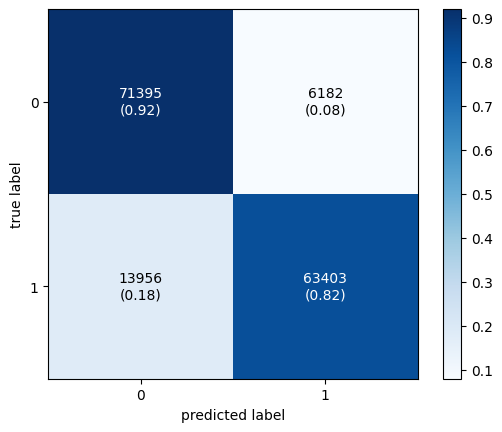

Test


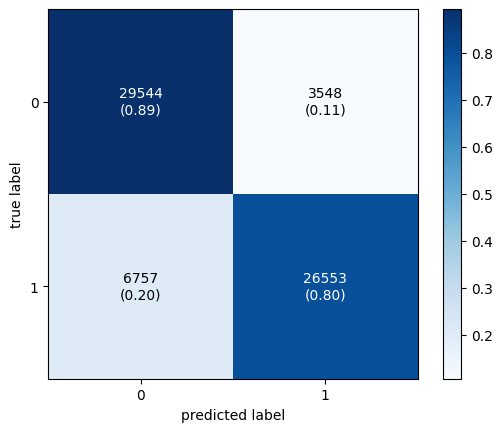

----------------------------------------------------------------------


In [ ]:
y_pred = [0 if (y<0.5)else 1 for y in y_pred]

print("----------------------------------------------------------------------")

print("Train")

y_pred_trean = model.predict_proba(X_train)[:,1]
y_pred_trean = [0 if (y<0.5)else 1 for y in y_pred_trean]

cm1 = confusion_matrix(y_train, y_pred_trean)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                        show_normed=True,
                        colorbar=True)
plt.show()

print("Test")
cm1 = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                        show_normed=True,
                        colorbar=True)
plt.show()

print("----------------------------------------------------------------------")

In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, y_pred, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_train, y_train, pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

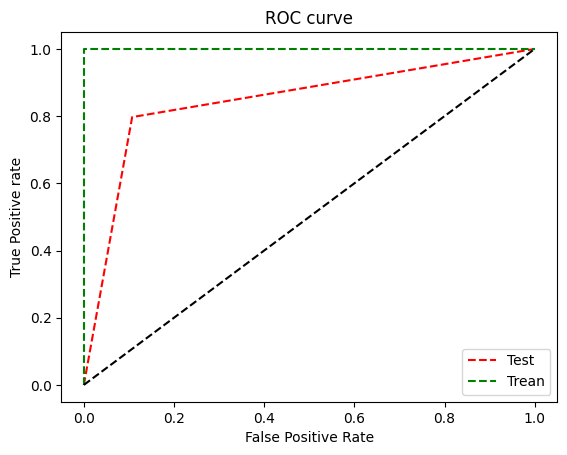

In [ ]:
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='r', label='Test')
plt.plot(fpr2, tpr2, linestyle='--',color='g', label='Trean')
plt.plot(p_fpr, p_tpr, linestyle='--', color='k')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [ ]:
from joblib import dump, load

dump(model, 'xgboost_model_pipeline.joblib')

['xgboost_model_pipeline.joblib']

In [ ]:
loaded_model = load('xgboost_model_pipeline.joblib')

In [ ]:
y_pred = loaded_model.predict_proba(X_test)[37,:]
y_pred.argmax()

np.int64(0)

In [ ]:
# Load the model
from joblib import load
loaded_model = load('/content/xgboost_model_pipeline.joblib')

# If your model is a pipeline, you can check the column transformer
# This assumes the first step in your pipeline is a ColumnTransformer
if hasattr(loaded_model, 'steps'):
    # Try to find a ColumnTransformer in the pipeline
    for step_name, step_transformer in loaded_model.steps:
        if hasattr(step_transformer, 'transformers_'):
            print(f"Found transformer: {step_name}")
            # Print the feature names if available
            if hasattr(step_transformer, 'feature_names_in_'):
                print(f"Expected features: {step_transformer.feature_names_in_}")
                print(f"Number of features expected: {len(step_transformer.feature_names_in_)}")

            # Look at individual transformers in the ColumnTransformer
            for name, transformer, columns in step_transformer.transformers_:
                print(f"Transformer: {name}, Columns: {columns}")

Found transformer: preprocessor
Expected features: ['HighBP' 'HighChol' 'CholCheck' 'BMI' 'Smoker' 'Stroke' 'PhysActivity'
 'Fruits' 'Veggies' 'HvyAlcoholConsump' 'AnyHealthcare' 'NoDocbcCost'
 'GenHlth' 'MentHlth' 'PhysHlth' 'DiffWalk' 'Sex' 'Age' 'Education'
 'Income']
Number of features expected: 20
Transformer: num, Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [ ]:
import numpy as np
from sklearn import metrics
from joblib import load

# Load the model
model_path = '/content/xgboost_model_pipeline.joblib'
try:
    loaded_model = load(model_path)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")

def predict_diabetes():
    # Get feature input from the user
    try:
        HighBP = int(input("Enter HighBP (adults told they have high blood pressure, 0 or 1): "))
        HighChol = int(input("Enter HighChol (ever told you have high cholesterol, 0 or 1): "))
        CholCheck = int(input("Enter CholCheck (cholesterol check within past five years, 0 or 1): "))
        BMI = int(input("Enter BMI: "))
        Smoker = int(input("Enter Smoker (smoked at least 100 cigarettes in entire life, 0 or 1): "))
        Stroke = int(input("Enter Stroke (ever told you had a stroke, 0 or 1): "))
        PhysActivity = int(input("Enter PhysActivity (exercise in past 30 days, 0 or 1): "))
        Fruits = int(input("Enter Fruits (consume fruit 1+ times per day, 0 or 1): "))
        Veggies = int(input("Enter Veggies (consume vegetables 1+ times per day, 0 or 1): "))
        HvyAlcoholConsump = int(input("Enter HvyAlcoholConsump (heavy drinker, 0 or 1): "))
        AnyHealthcare = int(input("Enter AnyHealthcare (have health coverage, 0 or 1): "))
        NoDocbcCost = int(input("Enter NoDocbcCost (couldn't see doctor due to cost in past 12 months, 0 or 1): "))
        GenHlth = int(input("Enter GenHlth (general health rating, 1-5): "))
        MentHlth = int(input("Enter MentHlth (days of poor mental health in past 30 days, 0-30): "))
        PhysHlth = int(input("Enter PhysHlth (days of poor physical health in past 30 days, 0-30): "))
        DiffWalk = int(input("Enter DiffWalk (difficulty walking/climbing stairs, 0 or 1): "))
        Sex = int(input("Enter Sex (0 for Female, 1 for Male): "))
        Age = int(input("Enter Age (fourteen-level age category, 1-14): "))
        Education = int(input("Enter Education (highest grade completed, 1-6): "))
        Income = int(input("Enter Income (annual household income level, 1-8): "))
        # Create a list of features
        features = [HighBP, HighChol, CholCheck, BMI, Smoker, Stroke,
                    PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare,
                    NoDocbcCost, GenHlth, MentHlth, PhysHlth, DiffWalk, Sex, Age,
                    Education, Income]

        # Convert features to a NumPy array and reshape for prediction
        features_array = np.array(features).reshape(1, -1)

        # Make prediction
        try:
            # Get probability score
            prob = loaded_model.predict_proba(features_array)[:,1][0]
            prediction = 1 if prob >= 0.5 else 0
            return f"Prediction: {'Diabetic' if prediction == 1 else 'Non-Diabetic'} (Probability: {prob:.2f})"
        except:
            # Fall back to simple prediction
            prediction = loaded_model.predict(features_array)[0]
            return f"Prediction: {'Diabetic' if prediction == 1 else 'Non-Diabetic'}"

    except Exception as e:
        return f"Error during prediction: {e}"

# To check model performance (if you have test data)
# Uncomment and run these lines separately as needed

# Assuming X_test and y_test are available
y_pred = loaded_model.predict_proba(X_test)[:,1]
score = metrics.roc_auc_score(y_test, y_pred)
print(f"Model ROC-AUC score: {score:.4f}")

# Example usage
prediction_result = predict_diabetes()
print(prediction_result)

Model loaded successfully!
Model ROC-AUC score: 0.9271
Enter HighBP (adults told they have high blood pressure, 0 or 1): 1
Enter HighChol (ever told you have high cholesterol, 0 or 1): 1
Enter CholCheck (cholesterol check within past five years, 0 or 1): 1
Enter BMI: 1
Enter Smoker (smoked at least 100 cigarettes in entire life, 0 or 1): 1
Enter Stroke (ever told you had a stroke, 0 or 1): 1
Enter PhysActivity (exercise in past 30 days, 0 or 1): 1
Enter Fruits (consume fruit 1+ times per day, 0 or 1): 1
Enter Veggies (consume vegetables 1+ times per day, 0 or 1): 1
Enter HvyAlcoholConsump (heavy drinker, 0 or 1): 1
Enter AnyHealthcare (have health coverage, 0 or 1): 1
Enter NoDocbcCost (couldn't see doctor due to cost in past 12 months, 0 or 1): 1
Enter GenHlth (general health rating, 1-5): 1
Enter MentHlth (days of poor mental health in past 30 days, 0-30): 1
Enter PhysHlth (days of poor physical health in past 30 days, 0-30): 1
Enter DiffWalk (difficulty walking/climbing stairs, 0 or

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 126.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import gradio as gr
import joblib

# Load the trained model
loaded_model = joblib.load('/content/xgboost_model_pipeline.joblib')
print("Model loaded successfully!")

# Define prediction function
def predict_diabetes(HighBP, HighChol, CholCheck, BMI, Smoker, Stroke,
                    PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare,
                    NoDocbcCost, GenHlth, MentHlth, PhysHlth, DiffWalk, Sex, Age,
                    Education, Income):
    # Create a list of features (without HeartDiseaseorAttack)
    features = [HighBP, HighChol, CholCheck, BMI, Smoker, Stroke,
                PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare,
                NoDocbcCost, GenHlth, MentHlth, PhysHlth, DiffWalk, Sex, Age,
                Education, Income]

    # Convert features to a NumPy array and reshape
    features_array = np.array(features).reshape(1, -1)

    # Make prediction with error handling
    try:
        prob = loaded_model.predict_proba(features_array)[:,1][0]
        prediction = 1 if prob >= 0.5 else 0
        result = f"{'Diabetic' if prediction == 1 else 'Non-Diabetic'} (Probability: {prob:.2f})"
    except Exception as e:
        print(f"Error during prediction: {e}")
        raise e

    return result

# Build Gradio Interface
with gr.Blocks(title="Diabetes Risk Prediction Tool") as demo:
    gr.Markdown("# Diabetes Risk Prediction Tool")
    gr.Markdown("Enter your health information below to assess your diabetes risk.")

    with gr.Row():
        with gr.Column():
            HighBP = gr.Radio([0, 1], label="High Blood Pressure (0=No, 1=Yes)",
                              info="Have you been told you have high blood pressure?", value=0)
            HighChol = gr.Radio([0, 1], label="High Cholesterol (0=No, 1=Yes)",
                                info="Have you been told you have high cholesterol?", value=0)
            CholCheck = gr.Radio([0, 1], label="Cholesterol Check (0=No, 1=Yes)",
                                 info="Had cholesterol check in past 5 years?", value=1)
            BMI = gr.Slider(10, 60, value=25, label="BMI", info="Body Mass Index")
            Smoker = gr.Radio([0, 1], label="Smoker (0=No, 1=Yes)",
                             info="Smoked at least 100 cigarettes in lifetime?", value=0)
            Stroke = gr.Radio([0, 1], label="History of Stroke (0=No, 1=Yes)",
                              info="Have you ever had a stroke?", value=0)

        with gr.Column():
            PhysActivity = gr.Radio([0, 1], label="Physical Activity (0=No, 1=Yes)",
                                   info="Exercise in past 30 days (other than regular job)?", value=1)
            Fruits = gr.Radio([0, 1], label="Fruit Consumption (0=No, 1=Yes)",
                             info="Eat fruit at least once per day?", value=1)
            Veggies = gr.Radio([0, 1], label="Vegetable Consumption (0=No, 1=Yes)",
                              info="Eat vegetables at least once per day?", value=1)
            HvyAlcoholConsump = gr.Radio([0, 1], label="Heavy Alcohol Consumption (0=No, 1=Yes)",
                                        info="Men: >14 drinks/week, Women: >7 drinks/week", value=0)
            AnyHealthcare = gr.Radio([0, 1], label="Healthcare Coverage (0=No, 1=Yes)",
                                    info="Do you have any kind of health insurance?", value=1)
            NoDocbcCost = gr.Radio([0, 1], label="Doctor Cost Barrier (0=No, 1=Yes)",
                                  info="Couldn't see doctor due to cost in past year?", value=0)
            GenHlth = gr.Slider(1, 5, step=1, value=3, label="General Health (1=Excellent, 5=Poor)",
                               info="Rate your general health")

    with gr.Row():
        with gr.Column():
            MentHlth = gr.Slider(0, 30, step=1, value=0, label="Mental Health (0-30 days)",
                                info="Days of poor mental health in past month")
            PhysHlth = gr.Slider(0, 30, step=1, value=0, label="Physical Health (0-30 days)",
                                info="Days of poor physical health in past month")
            DiffWalk = gr.Radio([0, 1], label="Difficulty Walking (0=No, 1=Yes)",
                               info="Serious difficulty walking or climbing stairs?", value=0)
            Sex = gr.Radio([0, 1], label="Sex (0=Female, 1=Male)", value=0)

        with gr.Column():
            Age = gr.Slider(1, 14, step=1, value=7, label="Age Category (1-14)",
                           info="1=18-24, 2=25-29, ..., 13=80+")
            Education = gr.Slider(1, 6, step=1, value=4, label="Education Level (1-6)",
                                 info="1=No school to 6=College graduate")
            Income = gr.Slider(1, 8, step=1, value=5, label="Income Level (1-8)",
                              info="1=<$10K to 8=>$75K")

    with gr.Row():
        predict_btn = gr.Button("Predict Diabetes Risk", variant="primary")

    output = gr.Textbox(label="Prediction Result")

    predict_btn.click(
        fn=predict_diabetes,
        inputs=[HighBP, HighChol, CholCheck, BMI, Smoker, Stroke,
                PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare,
                NoDocbcCost, GenHlth, MentHlth, PhysHlth, DiffWalk, Sex, Age,
                Education, Income],
        outputs=output
    )

    gr.Markdown("### Understanding the Results")
    gr.Markdown("- **Diabetic**: You may have or be at risk of diabetes based on your health inputs.")
    gr.Markdown("- **Non-Diabetic**: You likely do not have diabetes based on your inputs.")
    gr.Markdown("- **Probability**: The model's confidence level in its prediction.")
    gr.Markdown("*Note: This is an educational tool, not medical advice.*")

# Launch the Gradio app
demo.launch()

Model loaded successfully!
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://79f7cca4aa8b52a50e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
